<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/ia_mobile_TF_many_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
path = "/content/fulldataset.xlsx"

In [4]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

# Just extract out sentences and labels first - we will create subwords here
responsavel = dataset['Responsável'].tolist()
natureza = dataset['Natureza'].tolist()
classificacao = dataset['Classificação'].tolist()
produtos_servicos = dataset['Produtos/Serviços'].tolist()
detalhamento = dataset['Detalhamento'].tolist()
review = dataset['review'].tolist()
score = dataset['score'].tolist()

In [5]:
# Separate out the sentences and labels into training and test sets
training_size = int(len(review) * 0.8)

training_sentences = review[0:training_size]
testing_sentences = review[training_size:]
training_labels = classificacao[0:training_size]
testing_labels = classificacao[training_size:]



In [6]:
type(training_labels[2])

str

In [7]:
# Tokenizing classificacao
tokenizer = Tokenizer()
tokenizer.fit_on_texts(classificacao)
word_index = tokenizer.word_index
word_index

{'crítica': 3,
 'dúvida': 5,
 'elogio': 1,
 'neutra': 4,
 'reclamação': 2,
 'resposta': 8,
 'solicitação': 7,
 'sugestão': 6}

In [8]:
len(word_index)
tamanho_classes = len(word_index)+1

In [9]:
def transforming_labels(lista):
  temp = []
  for item in lista:
    temp.append(word_index.get(item.lower()))
  return temp

In [10]:
training_labels = transforming_labels(training_labels)
testing_labels = transforming_labels(testing_labels)

In [11]:
training_labels[0:20]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1]

In [12]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [13]:
training_labels_final

array([1, 1, 1, ..., 1, 1, 1])

In [14]:
print(training_sentences[0:5])

['O aplicativo possibilita fazer todas as movimentações e acompanhar seu andamento. È fàcil de utilizar, ràpido e possue todas as informações necessàrias ao cliente.', 'Bom', 'Muito bom, gosto muito', 'Muito bom', 'Muito bom tem me ajudado muito pois faço tudo sem precisar sair de casa👏👏👏👏👏']


In [15]:
print(training_labels[0:20], testing_labels[0:20])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1] [1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


# Tokenize the dataset
Tokenize the dataset, including padding and OOV

In [16]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, 
                       truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, 
                               padding=padding_type, truncating=trunc_type)

# Review a Sequence
Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [17]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, 'x') for i in text])

print(decode_review(padded[0]))
print(training_sentences[0])

o aplicativo <OOV> fazer todas as movimentações e acompanhar seu <OOV> è <OOV> de utilizar <OOV> e <OOV> todas as informações <OOV> ao cliente x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
O aplicativo possibilita fazer todas as movimentações e acompanhar seu andamento. È fàcil de utilizar, ràpido e possue todas as informações necessàrias ao cliente.


In [18]:
training_labels_final[1]

1

# Train a Basic Sentiment Model with Embeddings

In [19]:
# Build a basic sentiment network
# Note the embedding layer is first, 
# and the output is only 1 node as it is either 0 or 1 (negative or positive)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(50, activation='relu', input_shape=(100,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(tamanho_classes, activation='softmax')
])


# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           16000     
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               160100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 4

In [20]:
num_epochs = 5
hist = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/5
130/130 [==============================] - 1s 5ms/step - loss: 0.4394 - accuracy: 0.9135 - val_loss: 0.3241 - val_accuracy: 0.9114
Epoch 2/5
130/130 [==============================] - 0s 4ms/step - loss: 0.2121 - accuracy: 0.9451 - val_loss: 0.2491 - val_accuracy: 0.9326
Epoch 3/5
130/130 [==============================] - 0s 4ms/step - loss: 0.1637 - accuracy: 0.9583 - val_loss: 0.2483 - val_accuracy: 0.9345
Epoch 4/5
130/130 [==============================] - 0s 4ms/step - loss: 0.1284 - accuracy: 0.9651 - val_loss: 0.2575 - val_accuracy: 0.9374
Epoch 5/5
130/130 [==============================] - 0s 4ms/step - loss: 0.0998 - accuracy: 0.9709 - val_loss: 0.2947 - val_accuracy: 0.9383


In [21]:
scores = model.evaluate(testing_padded, testing_labels_final, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 6.17%


In [22]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

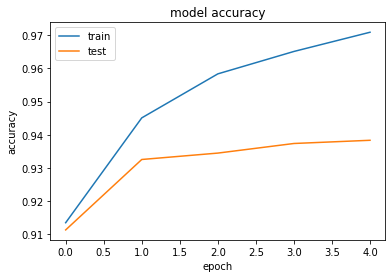

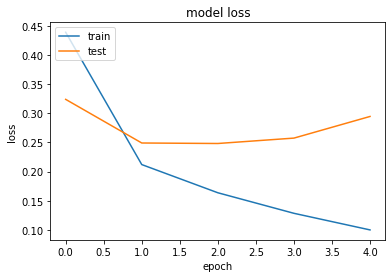

In [23]:
plt.plot(hist.history[ 'accuracy' ])
plt.plot(hist.history[ 'val_accuracy' ])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy')
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()
# summarize history for loss
plt.plot(hist.history[ 'loss' ])
plt.plot(hist.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()

# Novas Predições:

In [ ]:
path = "/content/predicao-arquivo-novo.xlsx"

In [24]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

# Just extract out sentences and labels first - we will create subwords here
responsavel = dataset['Responsável'].tolist()
natureza = dataset['Natureza'].tolist()
classificacao = dataset['Classificação'].tolist()
produtos_servicos = dataset['Produtos/Serviços'].tolist()
detalhamento = dataset['Detalhamento'].tolist()
review = dataset['review'].tolist()
score = dataset['score'].tolist()

In [55]:
# Use the model to predict a review   
fake_reviews = classificacao

print(fake_reviews) 

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)           

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

print(fake_reviews[17])
print(classes[17])

['Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Reclamação', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Reclamação', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', 'Elogio', '

In [56]:
classes[17]

array([4.6702224e-04, 9.3125880e-01, 5.8713481e-03, 2.4637101e-02,
       2.3840668e-02, 3.2887661e-03, 2.5023147e-03, 2.8410510e-03,
       5.2928203e-03], dtype=float32)

In [57]:
classes_list = classes.tolist()
classes_list[17].index(np.max(classes[17], axis=0, keepdims=True))

1

In [63]:
for item in classes_list:
classes_list[17].index(max(classes_list[17]))

1